In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- 1. GERAÇÃO DE SINAIS (REAL-VALUED) ---
np.random.seed(42)
n_samples = 4000
order = 4 # M=4 (5 coeficientes)

# Entrada: Ruído branco real
x = np.random.randn(n_samples)

# Planta Desconhecida (Sistema Real)
w_true = np.array([0.5, -0.4, 0.2, -0.1, 0.3])
d_clean = np.convolve(x, w_true, mode='full')[:n_samples]
# Adicionando ruído de medição
d = d_clean + 0.03 * np.random.randn(n_samples)

# --- 2. EXECUÇÃO DO SIGN-ERROR LMS ---
# O step_size no Sign-Error costuma ser menor que no LMS convencional
# porque a "magnitude" da atualização não diminui quando o erro fica pequeno.
filt_se = pdf.SignError(
    filter_order=order,
    step_size=0.005
)

result = filt_se.optimize(x, d, verbose=True)

[SignError] Completed in 11.593 ms


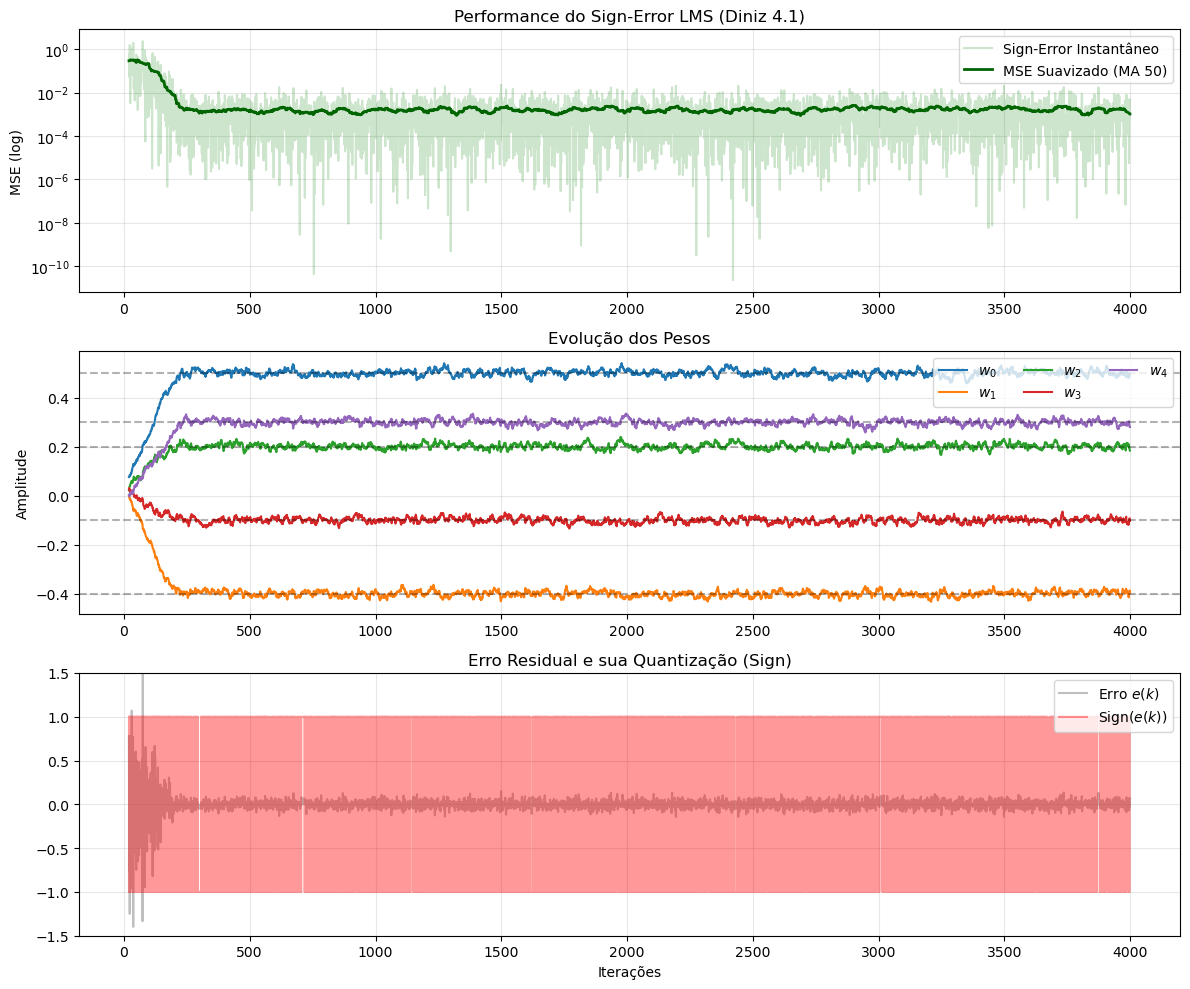

Erro Final Médio (últimas 100 amostras): 1.678660e-03


In [3]:
# --- 3. ANÁLISE VISUAL ---
offset = 20
mse = result.mse()
t = np.arange(len(mse))

# Sincronização do histórico de coeficientes
coeffs_history = result.coefficients
if coeffs_history.shape[0] > len(mse):
    coeffs_history = coeffs_history[1:]

plt.figure(figsize=(12, 10))

# Subplot 1: MSE (Curva de Aprendizado)
plt.subplot(3, 1, 1)
plt.semilogy(t[offset:], mse[offset:], label='Sign-Error Instantâneo', alpha=0.2, color='green')
mse_smooth = np.convolve(mse, np.ones(50)/50, mode='same')
plt.semilogy(t[offset:], mse_smooth[offset:], label='MSE Suavizado (MA 50)', color='darkgreen', lw=2)
plt.title('Performance do Sign-Error LMS (Diniz 4.1)')
plt.ylabel('MSE (log)')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# Subplot 2: Trajetória dos Coeficientes
plt.subplot(3, 1, 2)
for i in range(coeffs_history.shape[1]):
    plt.plot(t[offset:], coeffs_history[offset:, i], label=f'$w_{i}$')
    plt.axhline(y=w_true[i], color='black', linestyle='--', alpha=0.3)
plt.title('Evolução dos Pesos')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', ncol=3)

# Subplot 3: Erro e Sinal do Erro
plt.subplot(3, 1, 3)
plt.plot(t[offset:], result.errors[offset:], color='gray', alpha=0.5, label='Erro $e(k)$')
plt.step(t[offset:], np.sign(result.errors[offset:]), color='red', alpha=0.4, label='Sign($e(k)$)')
plt.title('Erro Residual e sua Quantização (Sign)')
plt.xlabel('Iterações')
plt.ylim([-1.5, 1.5])
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Erro Final Médio (últimas 100 amostras): {np.mean(mse[-100:]):.6e}")